# Project Title - Amazon Delivery Time Prediction

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from geopy.distance import geodesic
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import mlflow.sklearn
import joblib

## Data Cleaning

In [4]:
# Read the dataset
df = pd.read_csv('amazon_delivery.csv')
df.head()

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys


## Understanding the data

In [5]:
df.shape

(43739, 16)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.3+ MB


In [7]:
df.describe()

,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Delivery_Time
count,43739.000000,43685.000000,43739.000000,43739.000000,43739.000000,43739.000000,43739.000000
mean,29.567137,4.633780,17.210960,70.661177,17.459031,70.821842,124.905645
std,5.815155,0.334716,7.764225,21.475005,7.342950,21.153148,51.915451
min,15.000000,1.000000,-30.902872,-88.366217,0.010000,0.010000,10.000000
25%,25.000000,4.500000,12.933298,73.170283,12.985996,73.280000,90.000000
50%,30.000000,4.700000,18.551440,75.898497,18.633626,76.002574,125.000000
75%,35.000000,4.900000,22.732225,78.045359,22.785049,78.104095,160.000000
max,50.000000,6.000000,30.914057,88.433452,31.054057,88.563452,270.000000


In [11]:
df.duplicated().sum()

0

In [13]:
df.dtypes

Order_ID            object
Agent_Age            int64
Agent_Rating       float64
Store_Latitude     float64
Store_Longitude    float64
Drop_Latitude      float64
Drop_Longitude     float64
Order_Date          object
Order_Time          object
Pickup_Time         object
Weather             object
Traffic             object
Vehicle             object
Area                object
Delivery_Time        int64
Category            object
dtype: object

In [15]:
df.columns

Index(['Order_ID', 'Agent_Age', 'Agent_Rating', 'Store_Latitude',
       'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude', 'Order_Date',
       'Order_Time', 'Pickup_Time', 'Weather', 'Traffic', 'Vehicle', 'Area',
       'Delivery_Time', 'Category'],
      dtype='object')

In [9]:
df.isnull().sum()

Order_ID            0
Agent_Age           0
Agent_Rating       54
Store_Latitude      0
Store_Longitude     0
Drop_Latitude       0
Drop_Longitude      0
Order_Date          0
Order_Time          0
Pickup_Time         0
Weather            91
Traffic             0
Vehicle             0
Area                0
Delivery_Time       0
Category            0
dtype: int64

## Handling Missing Values

In [11]:
df = df.replace(r'^\s*NaN\s*$', np.nan, regex=True)

In [13]:
df.isnull().sum()

Order_ID            0
Agent_Age           0
Agent_Rating       54
Store_Latitude      0
Store_Longitude     0
Drop_Latitude       0
Drop_Longitude      0
Order_Date          0
Order_Time         91
Pickup_Time         0
Weather            91
Traffic            91
Vehicle             0
Area                0
Delivery_Time       0
Category            0
dtype: int64

In [15]:
# Identify rows with missing Order_Time values
missing_order_time = df['Order_Time'].isna()

In [17]:
# Function to subtract 10 minutes from a time string
def create_order_time(pickup_time):
    if pd.isna(pickup_time):
        return np.nan
    
    # Parse the pickup time string
    time_obj = datetime.strptime(pickup_time, '%H:%M:%S')
    
    # Subtract 10 minutes
    order_time = time_obj - timedelta(minutes=10)
    
    # Return as string in the same format
    return order_time.strftime('%H:%M:%S')

In [19]:
# Apply the function ONLY to rows where Order_Time is NaN
df.loc[missing_order_time, 'Order_Time'] = df.loc[missing_order_time, 'Pickup_Time'].apply(create_order_time)

In [23]:
# Fill missing values in using mean for numerical & mode for categoriacal columns
df['Agent_Rating'] = df['Agent_Rating'].fillna(df['Agent_Rating'].mean())
df['Weather'] = df['Weather'].fillna(df['Weather'].mode()[0])
df['Traffic'] = df['Traffic'].fillna(df['Traffic'].mode()[0])

In [25]:
df.isnull().sum()

Order_ID           0
Agent_Age          0
Agent_Rating       0
Store_Latitude     0
Store_Longitude    0
Drop_Latitude      0
Drop_Longitude     0
Order_Date         0
Order_Time         0
Pickup_Time        0
Weather            0
Traffic            0
Vehicle            0
Area               0
Delivery_Time      0
Category           0
dtype: int64

## Fixing Data Types

In [27]:
# Convert date, time columns
df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%Y-%m-%d', errors='coerce')
df['Order_Time'] = pd.to_datetime(df['Order_Time'], format='%H:%M:%S', errors='coerce')
df['Pickup_Time'] = pd.to_datetime(df['Pickup_Time'], format='%H:%M:%S', errors='coerce')

In [29]:
df.dtypes

Order_ID                   object
Agent_Age                   int64
Agent_Rating              float64
Store_Latitude            float64
Store_Longitude           float64
Drop_Latitude             float64
Drop_Longitude            float64
Order_Date         datetime64[ns]
Order_Time         datetime64[ns]
Pickup_Time        datetime64[ns]
Weather                    object
Traffic                    object
Vehicle                    object
Area                       object
Delivery_Time               int64
Category                   object
dtype: object

In [31]:
# Dropping Order_ID column there's no use for model training
df.drop('Order_ID', axis=1, inplace=True)

## Handling Outliers

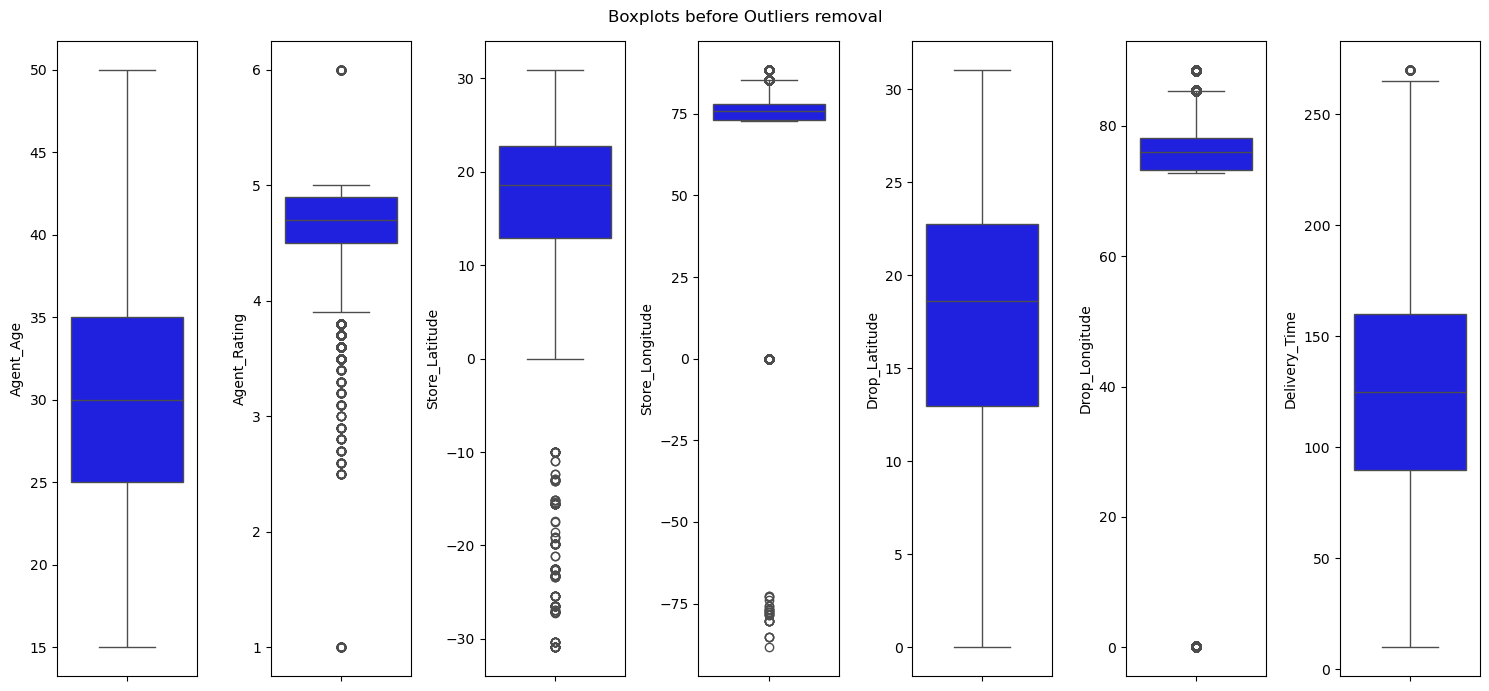

In [33]:
numerical_cols = ['Agent_Age','Agent_Rating', 'Store_Latitude', 'Store_Longitude', 'Drop_Latitude',
                  'Drop_Longitude', 'Delivery_Time']

plt.figure(figsize=(15, 7))
plt.suptitle("Boxplots before Outliers removal")
for i in range(0, len(numerical_cols)):
    plt.subplot(1, 7, i+1)
    sns.boxplot(y=df[numerical_cols[i]],color='blue',)
    plt.tight_layout()

**Observation:** A lower Agent_Rating (between 1 and 3) is possible, so it is not necessary to remove it as an outlier.

In [35]:
# Cap Agent_Rating values above 5 to 5
df['Agent_Rating'] = df['Agent_Rating'].apply(lambda x: 5 if x > 5 else x)

In [37]:
geo_columns = ['Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude']

In [39]:
for col in geo_columns:

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bound
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap values at lower and upper bound
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

In [41]:
# IQR capping for Delivery_Time
Q1 = df['Delivery_Time'].quantile(0.25)
Q3 = df['Delivery_Time'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Apply capping
df['Delivery_Time'] = df['Delivery_Time'].apply(
    lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
)

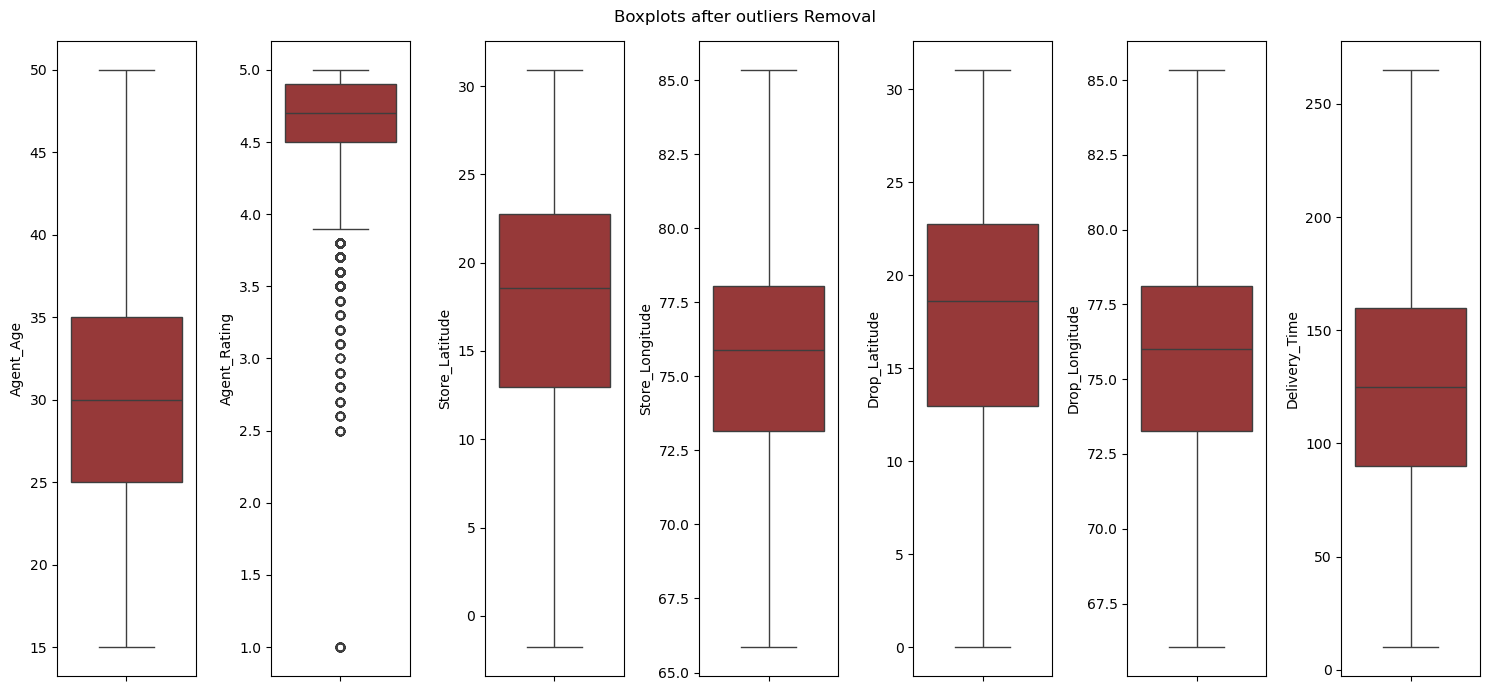

In [43]:
numerical_cols = ['Agent_Age','Agent_Rating', 'Store_Latitude', 'Store_Longitude', 'Drop_Latitude',
                  'Drop_Longitude', 'Delivery_Time']

plt.figure(figsize=(15, 7))
plt.suptitle("Boxplots after outliers Removal")
for i in range(0, len(numerical_cols)):
    plt.subplot(1, 7, i+1)
    sns.boxplot(y=df[numerical_cols[i]],color='brown')
    plt.tight_layout()

## New Feature Creation & Modification

In [45]:
# Calculate distance between store and drop location
def calc_geodesic_distance(row):
    store_coords = (row['Store_Latitude'], row['Store_Longitude'])
    drop_coords = (row['Drop_Latitude'], row['Drop_Longitude'])
    return geodesic(store_coords, drop_coords).kilometers

# Apply to each row
df['Distance_km'] = df.apply(calc_geodesic_distance, axis=1)

In [47]:
# Dropping the latitude and longitude columns after created distance column
df = df.drop(['Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude'], axis=1)

In [49]:
# Handle pickup time on the next day
df['Pickup_Time'] = df.apply(
    lambda row: row['Pickup_Time'] + pd.Timedelta(days=1)
    if row['Pickup_Time'] < row['Order_Time'] else row['Pickup_Time'],
    axis=1
)

In [51]:
# Calculate time differences
df['Order_to_Pickup_Minutes'] = (df['Pickup_Time'] - df['Order_Time']).dt.total_seconds() / 60

In [53]:
df = df.drop(['Order_Time', 'Pickup_Time'], axis=1)

In [55]:
# Extract day and month
df['Order_Day'] = df['Order_Date'].dt.day
df['Order_DayName'] = df['Order_Date'].dt.day_name()
df['Order_Month'] = df['Order_Date'].dt.month

In [57]:
df = df.drop(['Order_Date'], axis=1)

In [59]:
df.head()

,Agent_Age,Agent_Rating,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance_km,Order_to_Pickup_Minutes,Order_Day,Order_DayName,Order_Month
0,37,4.9,Sunny,High,motorcycle,Urban,120.0,Clothing,3.020737,15.0,19,Saturday,3
1,34,4.5,Stormy,Jam,scooter,Metropolitian,165.0,Electronics,20.143737,5.0,25,Friday,3
2,23,4.4,Sandstorms,Low,motorcycle,Urban,130.0,Sports,1.549693,15.0,19,Saturday,3
3,38,4.7,Sunny,Medium,motorcycle,Metropolitian,105.0,Cosmetics,7.774497,10.0,5,Tuesday,4
4,32,4.6,Cloudy,High,scooter,Metropolitian,150.0,Toys,6.197898,15.0,26,Saturday,3


In [61]:
# save cleaned data
df.to_csv('cleaned_data.csv', index=False)

## Encoding the categorical columns

### Nominal columns

In [63]:
nominal_data = ['Weather', 'Vehicle', 'Area', 'Category']

In [65]:
# Define One-Hot Encoder
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')


# Fit and Transform
encoded_array = ohe.fit_transform(df[nominal_data]).toarray()

# Convert Encoded Data to DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out(nominal_data))
encoded_df = encoded_df.astype(int)


# Concatenate with Original DataFrame (Drop Original Categorical Columns)
data = pd.concat([df.drop(columns=nominal_data), encoded_df], axis=1)

In [67]:
data.head()

,Agent_Age,Agent_Rating,Traffic,Delivery_Time,Distance_km,Order_to_Pickup_Minutes,Order_Day,Order_DayName,Order_Month,Weather_Fog,...,Category_Home,Category_Jewelry,Category_Kitchen,Category_Outdoors,Category_Pet Supplies,Category_Shoes,Category_Skincare,Category_Snacks,Category_Sports,Category_Toys
0,37,4.9,High,120.0,3.020737,15.0,19,Saturday,3,0,...,0,0,0,0,0,0,0,0,0,0
1,34,4.5,Jam,165.0,20.143737,5.0,25,Friday,3,0,...,0,0,0,0,0,0,0,0,0,0
2,23,4.4,Low,130.0,1.549693,15.0,19,Saturday,3,0,...,0,0,0,0,0,0,0,0,1,0
3,38,4.7,Medium,105.0,7.774497,10.0,5,Tuesday,4,0,...,0,0,0,0,0,0,0,0,0,0
4,32,4.6,High,150.0,6.197898,15.0,26,Saturday,3,0,...,0,0,0,0,0,0,0,0,0,1


### Ordinal

In [69]:
data['Traffic'].unique()

array(['High ', 'Jam ', 'Low ', 'Medium '], dtype=object)

In [71]:
traffic_order = ['Low ', 'Medium ', 'High ', 'Jam ']

# Define Encoder with Custom Order
ordinal_encoder = OrdinalEncoder(categories=[traffic_order])

# Fit and Transform
data['Traffic'] = ordinal_encoder.fit_transform(data[['Traffic']])

data['Traffic'] = data['Traffic'].astype(int)

In [73]:
data['Traffic'].unique()

array([2, 3, 0, 1])

In [75]:
data['Order_DayName'].unique()

array(['Saturday', 'Friday', 'Tuesday', 'Monday', 'Sunday', 'Wednesday',
       'Thursday'], dtype=object)

In [77]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Define Encoder with Custom Order
day_ordinal_encoder = OrdinalEncoder(categories=[day_order])

# Fit and Transform
data['Order_DayName'] = day_ordinal_encoder.fit_transform(data[['Order_DayName']])

data['Order_DayName'] = data['Order_DayName'].astype(int)

In [79]:
data['Order_DayName'].unique()

array([5, 4, 1, 0, 6, 2, 3])

In [81]:
data.head()

,Agent_Age,Agent_Rating,Traffic,Delivery_Time,Distance_km,Order_to_Pickup_Minutes,Order_Day,Order_DayName,Order_Month,Weather_Fog,...,Category_Home,Category_Jewelry,Category_Kitchen,Category_Outdoors,Category_Pet Supplies,Category_Shoes,Category_Skincare,Category_Snacks,Category_Sports,Category_Toys
0,37,4.9,2,120.0,3.020737,15.0,19,5,3,0,...,0,0,0,0,0,0,0,0,0,0
1,34,4.5,3,165.0,20.143737,5.0,25,4,3,0,...,0,0,0,0,0,0,0,0,0,0
2,23,4.4,0,130.0,1.549693,15.0,19,5,3,0,...,0,0,0,0,0,0,0,0,1,0
3,38,4.7,1,105.0,7.774497,10.0,5,1,4,0,...,0,0,0,0,0,0,0,0,0,0
4,32,4.6,2,150.0,6.197898,15.0,26,5,3,0,...,0,0,0,0,0,0,0,0,0,1


## Standard scaling for Distance_km

In [83]:
scaler = StandardScaler()
data['Distance_km'] = scaler.fit_transform(data[['Distance_km']])

In [85]:
data.head()

,Agent_Age,Agent_Rating,Traffic,Delivery_Time,Distance_km,Order_to_Pickup_Minutes,Order_Day,Order_DayName,Order_Month,Weather_Fog,...,Category_Home,Category_Jewelry,Category_Kitchen,Category_Outdoors,Category_Pet Supplies,Category_Shoes,Category_Skincare,Category_Snacks,Category_Sports,Category_Toys
0,37,4.9,2,120.0,-0.106003,15.0,19,5,3,0,...,0,0,0,0,0,0,0,0,0,0
1,34,4.5,3,165.0,-0.009540,5.0,25,4,3,0,...,0,0,0,0,0,0,0,0,0,0
2,23,4.4,0,130.0,-0.114290,15.0,19,5,3,0,...,0,0,0,0,0,0,0,0,1,0
3,38,4.7,1,105.0,-0.079223,10.0,5,1,4,0,...,0,0,0,0,0,0,0,0,0,0
4,32,4.6,2,150.0,-0.088104,15.0,26,5,3,0,...,0,0,0,0,0,0,0,0,0,1


In [87]:
data.columns

Index(['Agent_Age', 'Agent_Rating', 'Traffic', 'Delivery_Time', 'Distance_km',
       'Order_to_Pickup_Minutes', 'Order_Day', 'Order_DayName', 'Order_Month',
       'Weather_Fog', 'Weather_Sandstorms', 'Weather_Stormy', 'Weather_Sunny',
       'Weather_Windy', 'Vehicle_motorcycle ', 'Vehicle_scooter ',
       'Vehicle_van', 'Area_Other', 'Area_Semi-Urban ', 'Area_Urban ',
       'Category_Books', 'Category_Clothing', 'Category_Cosmetics',
       'Category_Electronics', 'Category_Grocery', 'Category_Home',
       'Category_Jewelry', 'Category_Kitchen', 'Category_Outdoors',
       'Category_Pet Supplies', 'Category_Shoes', 'Category_Skincare',
       'Category_Snacks', 'Category_Sports', 'Category_Toys'],
      dtype='object')

## Feature importances using Random Forest(Regression)

In [92]:
from sklearn.ensemble import RandomForestRegressor


X = data.drop(columns=['Delivery_Time'])
y = data['Delivery_Time']

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
feature_importance_df

,Feature,Importance
23,Category_Grocery,0.235214
1,Agent_Rating,0.170260
2,Traffic,0.124566
3,Distance_km,0.123194
0,Agent_Age,0.091196
11,Weather_Sunny,0.054907
8,Weather_Fog,0.025131
13,Vehicle_motorcycle,0.024333
5,Order_Day,0.021459
12,Weather_Windy,0.017730


## Bar Graph for Feature Importance

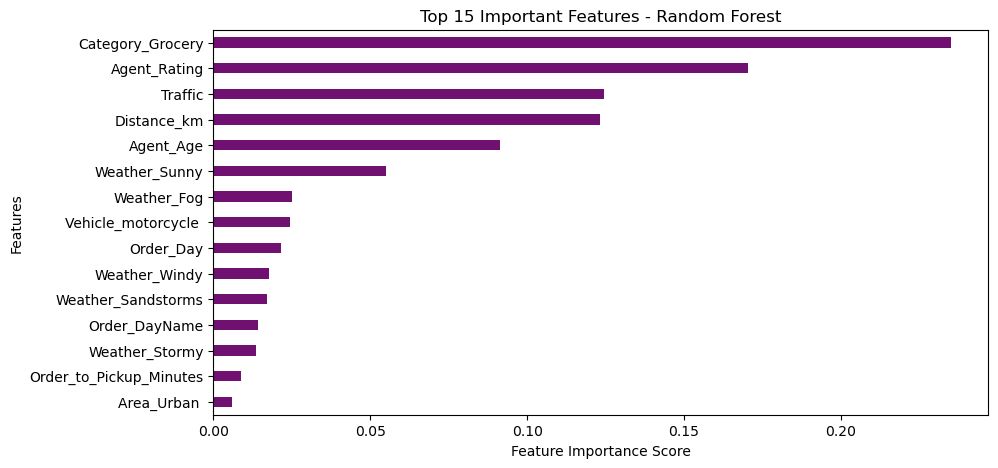

In [95]:
plt.figure(figsize=(10,5))
sns.barplot(x=feature_importance_df['Importance'][:15], y=feature_importance_df['Feature'][:15], color='purple', width=0.4)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 15 Important Features - Random Forest")
plt.show()

In [106]:
# columns to consider

feature_importance_df['Feature'][:10].tolist()

['Category_Grocery',
 'Agent_Rating',
 'Traffic',
 'Distance_km',
 'Agent_Age',
 'Weather_Sunny',
 'Weather_Fog',
 'Vehicle_motorcycle ',
 'Order_Day',
 'Weather_Windy']

## Model building (Regression)

In [108]:
# Select features
features = [
    'Category_Grocery', 'Agent_Rating', 'Traffic', 'Distance_km',
    'Agent_Age', 'Weather_Sunny', 'Weather_Fog', 'Vehicle_motorcycle ',
    'Order_Day', 'Weather_Windy'
]

X = data[features]
y = data['Delivery_Time']

In [110]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost Regressor": XGBRegressor()
}
# Train and evaluate models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict on test data

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2 Score": r2
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df

,MAE,MSE,RMSE,R2 Score
Linear Regression,27.292495,1193.631415,34.548971,0.551572
Decision Tree Regressor,26.301269,1267.322502,35.599473,0.523887
Random Forest Regressor,20.280502,708.594611,26.619440,0.733792
Gradient Boosting,20.812277,709.342608,26.633487,0.733511
XGBoost Regressor,19.757269,647.932153,25.454511,0.756582


**Observation:** I performed feature importance analysis and achieved an R² score of 75%. However, when I trained the model without applying feature selection, the R² score improved to 80%, indicating better performance.

In [85]:
# Select features
X = data.drop(columns=['Delivery_Time'])
y = data['Delivery_Time']

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
# Define models with optimized hyperparameters
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

In [91]:
# MLflow Setup
mlflow.set_experiment("Amazon Delivery Time Prediction")

2025/04/10 20:00:36 INFO mlflow.tracking.fluent: Experiment with name 'Amazon Delivery Time Prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///D:/GUVI-DS/Mini-Project_3_New/mlruns/378526713669649690', creation_time=1744295436752, experiment_id='378526713669649690', last_update_time=1744295436752, lifecycle_stage='active', name='Amazon Delivery Time Prediction', tags={}>

In [115]:
best_score = -np.inf
best_model_name = None
best_model = None

In [117]:
# Store metrics for all models
results = []

In [119]:
# Train and evaluate models
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        # Metrics
        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_score = cross_val_score(model, X, y, cv=cv, scoring='r2').mean()

        # Log to MLflow
        mlflow.log_param("Model", name)
        mlflow.log_metric("R2", r2)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("MSE", mse)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("CV R2", cv_score)
        mlflow.sklearn.log_model(model, "model")

        # Store in results
        results.append({
            "Model": name,
            "R2": r2,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "CV R2": cv_score
        })

        # Save best
        if cv_score > best_score:
            best_score = cv_score
            best_model_name = name
            best_model = model

2025/04/10 21:15:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/10 21:18:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/10 21:19:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/10 21:19:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/10 21:19:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [133]:
# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="CV R2", ascending=False).reset_index(drop=True)
results_df_path = "model_results.csv"
results_df.to_csv(results_df_path, index=False)
mlflow.log_artifact(results_df_path)

results_df.head()

,Model,R2,MAE,MSE,RMSE,CV R2
0,XGBoost,0.805017,17.781399,519.007568,22.781738,0.801335
1,Random Forest,0.801032,17.685567,529.614697,23.013359,0.796651
2,Gradient Boosting,0.755098,19.977032,651.883853,25.532016,0.752066
3,Decision Tree Regressor,0.615513,23.771376,1023.430956,31.991107,0.625882
4,Linear Regression,0.576814,26.660449,1126.441342,33.562499,0.575190


## Hyperparameter Tuning for the best model of XGBoost using RandomizedSearchCV

In [123]:
if best_model_name == "XGBoost":
    with mlflow.start_run(run_name="XGBoost Tuned"):
        param_dist = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

        rs = RandomizedSearchCV(XGBRegressor(random_state=42), param_distributions=param_dist, 
                                n_iter=20, cv=cv, scoring='r2', random_state=42, n_jobs=-1)
        rs.fit(X_train, y_train)
        tuned_model = rs.best_estimator_

        # Predict & metrics
        preds = tuned_model.predict(X_test)
        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)

        # Log tuned parameters & metrics
        mlflow.log_params(rs.best_params_)
        mlflow.log_metric("Tuned R2", r2)
        mlflow.log_metric("Tuned MAE", mae)
        mlflow.log_metric("Tuned MSE", mse)
        mlflow.log_metric("Tuned RMSE", rmse)

        # Save the final model
        mlflow.sklearn.log_model(tuned_model, "tuned_model")
        best_model = tuned_model

        print("\n✅ XGBoost tuned and logged to MLflow.")

2025/04/10 21:23:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✅ XGBoost tuned and logged to MLflow.


In [125]:
# Save the Best Model
joblib.dump(best_model, "best_model.pkl")
print("💾 Best model saved as best_model.pkl")

💾 Best model saved as best_model.pkl
